In [1]:
%matplotlib notebook
import pandas as pd, numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier as cart_clf
from sklearn.model_selection import train_test_split
from sklearn.tree._tree import TREE_LEAF
from sklearn.metrics import accuracy_score

data = pd.read_csv('spam.data.csv', delimiter = ' ', header = None)
X, y = data.iloc[:, :-1].values, data.iloc[:, -1:].values.flatten()

In [2]:
cart_model = cart_clf(random_state=0)

### Part b and c

In [3]:
def countLeafNodes(tree, root, count) :
    left = t.children_left[root]
    right = t.children_right[root]
    
    if left == right == TREE_LEAF :
        return count + 1
    elif left == TREE_LEAF != right:
        return countLeafNodes(t, right, count)
    elif left != TREE_LEAF == right:
        return countLeafNodes(t, left, count)
    else :
        return countLeafNodes(t, left, count) + countLeafNodes(t, right, count)
    
# prune leaves at a given depth
def pruneLeaves(tree, root, rem_depth) :
    if root == TREE_LEAF : return
    
    if rem_depth == 0 :
        tree.children_left[root] = tree.children_left[root] = TREE_LEAF
        return
    
    left = tree.children_left[root]
    right = tree.children_right[root]
    
    pruneLeaves(tree, left, rem_depth - 1)
    pruneLeaves(tree, right, rem_depth - 1)
    
def cross_validation(X, y, size ) :
    scores = []
    for i in range(size) :
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1.0/size) #random selection

        cart_model.fit(X_train, y_train)

        y_pred = cart_model.predict(X_test)
        scores.append(accuracy_score(y_test,y_pred))
    np_score = np.hstack(scores)
    return 1.0 - np.mean(np_score)

In [4]:
#original
print ("original score {}".format(round((cross_validation(X, y, size = 10)),3)))
max_depth = cart_model.tree_.max_depth
print("Max depth of tree {}".format(max_depth))
min_score = 1.0
min_index = -1

'''
for i in range(max_depth, 0, -1) :
    score = round(cross_validation(X, y, size = 10),3)
    (min_index, min_score) = (i, score) if score < min_score else (min_index, min_score)
    print("Pruning {} --> {}".format(i, score))
    pruneLeaves( tree=cart_model.tree_, root = 0, rem_depth = i )


print("Optimal tree by pruning last {} levels and score : {}".format (max_depth - min_index, min_score))
''' 


original score 0.088
Max depth of tree 30


'\nfor i in range(max_depth, 0, -1) :\n    score = round(cross_validation(X, y, size = 10),3)\n    (min_index, min_score) = (i, score) if score < min_score else (min_index, min_score)\n    print("Pruning {} --> {}".format(i, score))\n    pruneLeaves( tree=cart_model.tree_, root = 0, rem_depth = i )\n\n\nprint("Optimal tree by pruning last {} levels and score : {}".format (max_depth - min_index, min_score))\n'

In [5]:
def two_leaf_nodes(tree, nodes):
    def is_leaf(node, tree = tree):
        if node != TREE_LEAF and tree.children_left[node] == TREE_LEAF: return True
        else: return False
    return [node for node in nodes if is_leaf(tree.children_left[node]) 
                and is_leaf(tree.children_right[node])]

def make_node_leaf(node, tree, nodes):
    nodes.remove(tree.children_left[node])
    nodes.remove(tree.children_right[node])
    pruned_nodes = [tree.children_left[node], tree.children_right[node]]
    tree.children_left[node] = tree.children_right[node] = TREE_LEAF
    return nodes, pruned_nodes

def prune_worst_node_pair(clf_cart, nodes, X_test, y_test):
    tree = clf_cart.tree_
    two_leaf_nodes_ = two_leaf_nodes(tree, nodes)
    errs = []
    for node in two_leaf_nodes_:
        left, right = tree.children_left[node], tree.children_right[node]
        tree.children_left[node] = tree.children_right[node] = TREE_LEAF
        errs.append(1 - accuracy_score(clf_cart.predict(X_test), y_test))
        tree.children_left[node], tree.children_right[node] = left, right
    argmin_errs = np.argmin(errs)
    err = errs[argmin_errs]
    nodes, pruned_node_pair = make_node_leaf(two_leaf_nodes_[argmin_errs], tree, nodes)
    return err, pruned_node_pair, nodes

In [22]:
from copy import deepcopy

def cross_val_prune(clf_cart, folds = 3, pairs_to_prune = 10):
    errs = np.zeros(shape = (folds, pairs_to_prune))
    unpruned_clfs, pruned_clfs = [], []
    split_indices = list(KFold(n_splits = folds, shuffle = True).split(X))
    for fold_nu in range(folds):
        train_index, test_index = split_indices[fold_nu]
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf_cart.fit(X_train, y_train)
        unpruned_clfs.append(deepcopy(clf_cart))
        nodes = range(clf_cart.tree_.node_count)
        for prune_nu in range(pairs_to_prune):
            errs[fold_nu, prune_nu], pruned_node_pair, nodes = prune_worst_node_pair(clf_cart \
            , nodes, X_test, y_test)
        pruned_clfs.append(deepcopy(clf_cart))
    least_err_arg = np.argmin(errs[:, -1])
    unpruned_clf, pruned_clf = unpruned_clfs[least_err_arg], pruned_clfs[least_err_arg]
    errs_mean = np.mean(errs, axis = 0)
    return errs_mean, unpruned_clf, pruned_clf

<IPython.core.display.Javascript object>


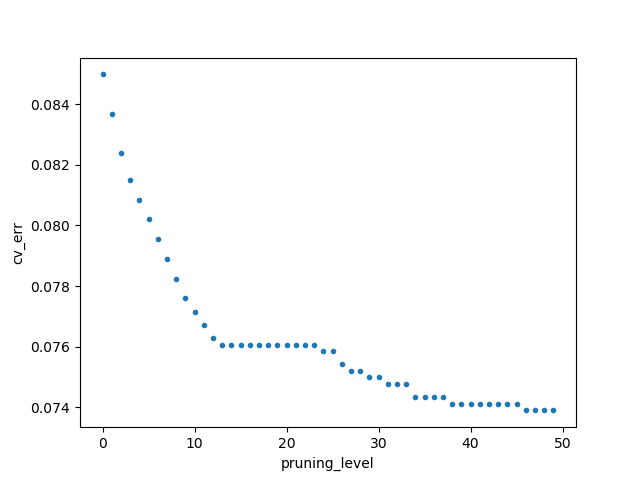

In [23]:
from matplotlib import pyplot as plt

cv_errs, unpruned_clf, pruned_clf = cross_val_prune(cart_clf(random_state = 0), pairs_to_prune = 50)
ax = plt.subplots()[1]
ax.set_xlabel('pruning_level'); ax.set_ylabel('cv_err')
ax.plot(range(len(cv_errs)), cv_errs, linestyle = '', marker = '.')